# Reveal the most representative day-types based on your analysis


| Model | Silhoutte Score | Davies Bouldin Score | Calinski Harabbasz Score | MAE | MAPE | Evaluation Metric|
| -------- |------- | ------- | -------- | -------- | -------- | -------- |
| kNN |0.26924|1.23140|118.0547|129.77361|8.4901|9.2775|
| Agglomerative |0.26377| 1.35879 |159.13421 | 59.98866 |3.31836|10.7863|
| DBSCAN | 0.28358 | 2.22541 |9.93803|60.67715|3.35730|0.3044|
| GNN | 0.31493 |1.07859 |112.19560|128.16948 |8.40844|12.0161|

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

In [2]:
data_df = pd.read_csv("dataset_exercise_5_clustering_highway_traffic.csv",sep=";")
data_df

,PORTAL,Date,time_from,time_to,Interval_5,SPEED_MS_AVG,flow
0,"E4S 56,780",20210101,00:00:00,00:05:00,0,18.56,39
1,"E4S 56,780",20210101,00:05:00,00:10:00,1,20.39,18
2,"E4S 56,780",20210101,00:10:00,00:15:00,2,19.27,26
3,"E4S 56,780",20210101,00:15:00,00:20:00,3,19.52,52
4,"E4S 56,780",20210101,00:20:00,00:25:00,4,20.52,52
...,...,...,...,...,...,...,...
104838,"E4S 56,780",20211231,23:35:00,23:40:00,283,19.58,115
104839,"E4S 56,780",20211231,23:40:00,23:45:00,284,19.47,87
104840,"E4S 56,780",20211231,23:45:00,23:50:00,285,19.77,130
104841,"E4S 56,780",20211231,23:50:00,23:55:00,286,18.79,129


## Data Preparation

In [3]:
# Sort the DataFrame 'data_df' by columns "Date" and "Interval_5"
data_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted DataFrame
days = np.unique(data_df[['Date']].values.ravel())
# Calculate the total number of unique days
ndays = len(days)

# Group the DataFrame 'data_df' by the "Date" column
day_subsets_df = data_df.groupby(["Date"])

# Define the total number of 5-minute intervals in a day
nintvals = 288

# Create a matrix 'vectorized_day_dataset' filled with NaN values
vectorized_day_dataset = np.zeros((ndays, nintvals))
vectorized_day_dataset.fill(np.nan)

# Loop through each unique day
for i in range(0, ndays):
    # Get the DataFrame corresponding to the current day
    df_t = day_subsets_df.get_group(days[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame
        df_t = day_subsets_df.get_group(days[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset'
        vectorized_day_dataset[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset'
print(vectorized_day_dataset)

[[ 39.  18.  26. ...  32.  39.  34.]
 [ 30.  32.  27. ...  44.  41.  39.]
 [ 36.  44.  52. ...  50.  45.  23.]
 ...
 [ 20.  34.  31. ...  38.  42.  36.]
 [ 36.  40.  25. ...  38.  56.  35.]
 [ 33.  32.  34. ... 130. 129. 117.]]


## Data Exploration

In [4]:
print('number of nans',np.sum(np.isnan(vectorized_day_dataset)))
print('rate of nans',np.sum(np.isnan(vectorized_day_dataset))/(ndays*nintvals))

number of nans 277
rate of nans 0.0026350837138508373


(288,)


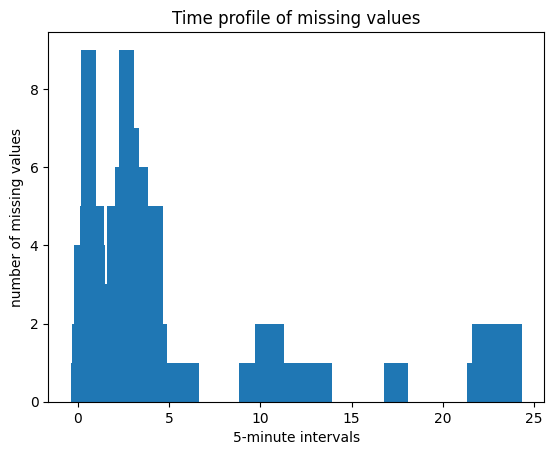

In [5]:
nans_per_time = np.sum(np.isnan(vectorized_day_dataset),0)
print(nans_per_time.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
# Create an array 'x_axis' representing the 5-minute intervals
x_axis = np.arange(0, nintvals, 1, dtype=int)
# Initialize an empty list 'x_axis_hours' to store time values in hours
x_axis_hours = []
# Convert interval indices to hours and append them to 'x_axis_hours'
for i in range(0, len(x_axis)):
  x_axis_hours.append(float(x_axis[i]*5)/60)
ax.bar(x_axis_hours,height=nans_per_time)


ax.set_ylabel('number of missing values')
ax.set_xlabel('5-minute intervals')
ax.set_title('Time profile of missing values')

plt.show()

In [6]:
nans_per_day = np.sum(np.isnan(vectorized_day_dataset),1)
print('number of days with missing value',np.size(np.where(nans_per_day > 0),1))

number of days with missing value 28


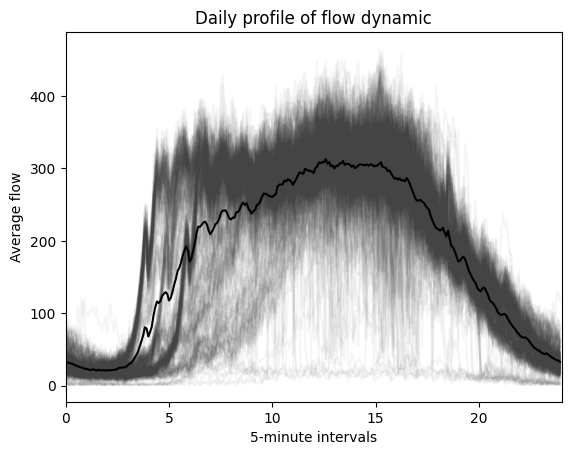

In [7]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()# a convenient way to create a new figure and a set of subplots.
ax.plot(np.array([x_axis_hours,]*ndays).transpose(),vectorized_day_dataset.transpose(),color='#444444',alpha=0.05)
# Above line plots the dataset with specified color and transparency.
ax.plot(x_axis_hours,np.transpose(np.nanmean(vectorized_day_dataset,0)),color='black')
# Above line plots the average of the dataset in black color.

ax.set_ylabel('Average flow')
ax.set_xlabel('5-minute intervals')
plt.xlim(0,24)
ax.set_title('Daily profile of flow dynamic')

plt.show()

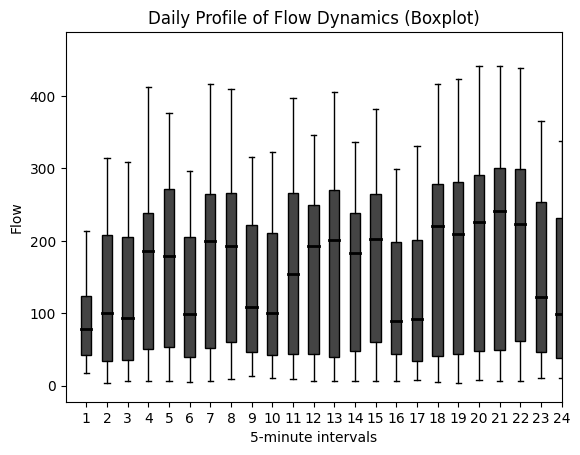

In [8]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()  # This line is a convenient way to create a new figure and a set of subplots.

# Create a boxplot for the dataset
boxplot = ax.boxplot(vectorized_day_dataset.T, patch_artist=True)

# Customize the boxplot appearance
for patch in boxplot['boxes']:
    patch.set_facecolor('#444444')  # Set the box color to gray
for median in boxplot['medians']:
    median.set(color='black', linewidth=2)  # Set median line color to black

# Set the y-axis label
ax.set_ylabel('Flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics (Boxplot)')

# Display the plot
plt.show()

In [9]:
import datetime

# Create an array 'day_of_week' to store the day of the week for each unique date
day_of_week = np.zeros((ndays))

# Loop through each unique date
for i in range(0, ndays):
    # Parse the current date from a string to a datetime object
    day_dt = datetime.datetime.strptime(str(days[i]), '%Y%m%d')

    # Get the day of the week (1 for Monday, 2 for Tuesday, ..., 7 for Sunday)
    day_of_week[i] = day_dt.isoweekday()

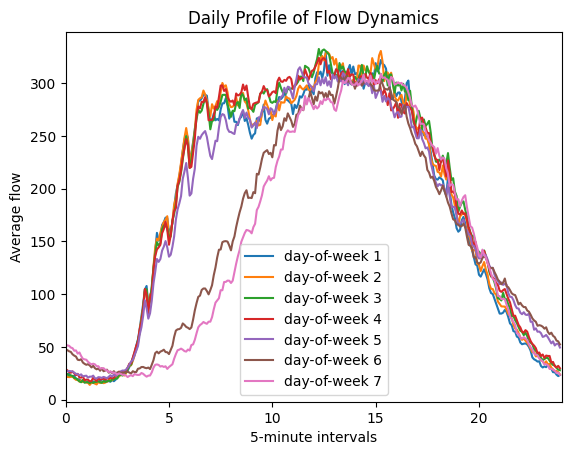

In [10]:
# Create a new figure and axis object using subplots
fig, ax = plt.subplots()

# Iterate through each day of the week (from 1 to 7)
for i in range(1, 8):
    # Find the indices of days that correspond to the current day of the week
    day_of_week_index_t = np.where(day_of_week == i)

    # Calculate the number of days that match the current day of the week
    ndays_t = np.size(day_of_week_index_t[0])

    # Plot the average flow for the current day of the week
    ax.plot(x_axis_hours,
            np.nanmean(vectorized_day_dataset[day_of_week_index_t[0], :].transpose(), 1),
            label='day-of-week ' + str(i))
    # This line plots the average flow for the current day of the week.
    # 'np.nanmean()' calculates the mean while handling NaN values.

# Set the y-axis label
ax.set_ylabel('Average flow')

# Set the x-axis label
ax.set_xlabel('5-minute intervals')

# Set the x-axis limits to be between 0 and 24
plt.xlim(0, 24)

# Set the title of the plot
ax.set_title('Daily Profile of Flow Dynamics')

# Add a legend indicating the day of the week
ax.legend()

# Display the plot
plt.show()

### Vectorizing Evaluation Data

In [11]:
# Read the evaluation dataset from a CSV file
data_eval_df = pd.read_csv("evaluation_dataset_exercise_5_clustering_highway_traffic.csv", sep=";")

# Sort the evaluation DataFrame by columns "Date" and "Interval_5"
data_eval_df.sort_values(["Date", "Interval_5"])

# Extract unique dates from the sorted evaluation DataFrame
days_eval = np.unique(data_eval_df[['Date']].values.ravel())
# Calculate the total number of unique days in the evaluation dataset
ndays_eval = len(days_eval)

# Group the evaluation DataFrame by the "Date" column
day_eval_subsets_df = data_eval_df.groupby(["Date"])

# Initialize a matrix 'vectorized_day_dataset_eval' filled with NaN values
vectorized_day_dataset_eval = np.zeros((ndays_eval, nintvals))
vectorized_day_dataset_eval.fill(np.nan)
# This section initializes a 2D array to store the evaluation dataset and fills it with NaN values.

# Loop through each unique day in the evaluation dataset
for i in range(0, ndays_eval):
    # Get the DataFrame corresponding to the current day
    df_t = day_eval_subsets_df.get_group(days_eval[i])

    # Loop through each row in the current day's DataFrame
    for j in range(len(df_t)):
        # Get the current day's DataFrame (this line is redundant)
        df_t = day_eval_subsets_df.get_group(days_eval[i])

        # Extract the "Interval_5" and "flow" values and populate 'vectorized_day_dataset_eval'
        vectorized_day_dataset_eval[i, df_t.iloc[j]["Interval_5"]] = df_t.iloc[j]["flow"]

# Print the resulting 'vectorized_day_dataset_eval'
print(vectorized_day_dataset_eval)

[[16.74 17.57 16.94 ... 19.43 19.88 19.73]
 [19.17 19.26 20.98 ... 19.34 21.22 19.79]
 [19.69 19.39 19.76 ... 20.51 20.5  19.6 ]
 ...
 [19.65 22.59 20.8  ... 19.23 20.32 20.18]
 [19.75 19.96 20.95 ... 17.95 19.14 19.55]
 [20.82 20.28 20.5  ... 19.72 20.64 20.23]]


In [12]:
# Calculate the total number of NaN values in the evaluation dataset
print('Number of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)))

# Calculate the rate of NaN values in the evaluation dataset
print('Rate of NaNs:', np.sum(np.isnan(vectorized_day_dataset_eval)) / (ndays_eval * nintvals))

# Calculate the number of days with missing values
nans_per_day_eval = np.sum(np.isnan(vectorized_day_dataset_eval), 1)
print('Number of days with missing values:', np.size(np.where(nans_per_day_eval > 0)))

# Filter out days with no missing values and create a new dataset
vectorized_day_dataset_no_nans_eval = vectorized_day_dataset_eval[np.where(nans_per_day_eval == 0)[0], :]
days_not_nans_eval = days_eval[np.where(nans_per_day_eval == 0)[0]]

# Calculate the final number of days in the evaluation dataset after removing missing values
print('Final number of days in evaluation dataset:', len(days_not_nans_eval))

# Print the list of days in the evaluation dataset with no missing values
print('List of days without missing values:', days_not_nans_eval)

# Calculate the total number of days in the filtered evaluation dataset
ndays_eval_not_nans = len(days_not_nans_eval)

Number of NaNs: 96
Rate of NaNs: 0.004166666666666667
Number of days with missing values: 11
Final number of days in evaluation dataset: 69
List of days without missing values: [20220108 20220109 20220131 20220204 20220209 20220210 20220211 20220223
 20220226 20220227 20220302 20220304 20220305 20220306 20220310 20220314
 20220315 20220321 20220323 20220326 20220403 20220406 20220416 20220418
 20220421 20220422 20220425 20220427 20220428 20220503 20220505 20220514
 20220519 20220521 20220522 20220526 20220530 20220601 20220603 20220609
 20220616 20220619 20220623 20220628 20220704 20220711 20220712 20220904
 20220910 20220911 20220920 20220921 20220925 20220927 20220929 20220930
 20221005 20221022 20221024 20221114 20221116 20221121 20221122 20221213
 20221216 20221218 20221220 20221223 20221230]



### Visualisation

In [13]:

from dateutil.relativedelta import relativedelta
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch
from matplotlib import colors

def assign_colors(n_clusters, days, assigments):

    days_colors = []
    color_to_cluster = []
    style_to_cluster = []
    weekend_colors = ['#67001f','#d6604d','#fdae61','#f46d43','#d53e4f','#9e0142','#f768a1','#f1c232']#,'#fe9929','#cc4c02','#e31a1c','#737373','#bdbdbd','#252525','#bcbddc']
#    weekend_school_colors = ['#c2a5cf','#f1b6da','#8e0152','#c51b7d','#de77ae','#ae017e','#fcc5c0','#e31a1c','#737373','#bdbdbd']
#    bank_holidays_colors = ['#543005','#dfc27d','#bf812d','#8c510a']
    mixed_colors = ['#4d4d4d','#35978f','#bababa','#878787']
    weekday_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#cab2d6','#6a3d9a','#b15928','#8dd3c7','#bebada','#fb8072','#b3de69','#bc80bd','#fccde5','#ccebc5','#35978f','#80cdc1']

    cluster_id_weekdays_share = []
    cluster_id_weekend_share = []
    cluster_id_all_days = []

    for i in range(0,n_clusters):
        color_to_cluster.append(None)
        style_to_cluster.append(None)
        cluster_id_weekdays_share.append(0)
        cluster_id_weekend_share.append(0)
        cluster_id_all_days.append(0)

    for i in range(0,len(days)):
        #print(i,assigments[i],len(assigments),len(cluster_id_all_days))
        if assigments[i] is not None:
            cluster_id_all_days[assigments[i]] += 1
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')

            if int(pomT.weekday()) < 5:
                cluster_id_weekdays_share[assigments[i]] += 1
            else:
                cluster_id_weekend_share[assigments[i]] += 1

    print('cluster_id_weekdays_share',cluster_id_weekdays_share)
    print('cluster_id_weekend_share',cluster_id_weekend_share)
    for i in range(0,len(days)):
        if assigments[i] is not None:
            cluster_idx = assigments[i]
            if '-' in str(days[i]):
                pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
            else:
                pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
            if color_to_cluster[assigments[i]] is None:
                if cluster_id_weekend_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekend_colors.pop()
                        style_to_cluster[assigments[i]] = ':'
                elif cluster_id_weekdays_share[cluster_idx] / float(cluster_id_all_days[cluster_idx]) > 0.6:
                        color_to_cluster[assigments[i]] = weekday_colors.pop(0)
                        style_to_cluster[assigments[i]] = '-'
                else:
                    color_to_cluster[assigments[i]] = mixed_colors.pop()
                    style_to_cluster[assigments[i]] = ':'

            days_colors.append(color_to_cluster[assigments[i]])
        else:
            days_colors.append(None)

    return days_colors,color_to_cluster,style_to_cluster


def calmap(ax, year, data, days, assigments, n_clusters,days_colors,color_to_cluster,
           limit_graphics=False):

    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders

    xticks, labels = [], []
    start = datetime.datetime(year,1,1).weekday()

    for month in range(1,13):

        first = datetime.datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]

        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",

                       linewidth=1, zorder=20, clip_on=False)

        ax.add_artist(poly)

    line = Line2D([0,53],[5,5],linewidth=1, zorder = 20,color="black",linestyle='dashed')
    ax.add_artist(line)

    if not limit_graphics:
        ax.set_xticks(xticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(0.5 + np.arange(7))
        ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
        ax.set_title("{}".format(year), weight="semibold")
    else:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False)

    # Clearing first and last day from the data
    valid = datetime.datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime.datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    for i in range(0,len(days)):
        if '-' in str(days[i]):
            pomT = datetime.datetime.strptime(str(days[i]),'%Y-%m-%d')
        else:
            pomT = datetime.datetime.strptime(str(days[i]),'%Y%m%d')
        week_number = int(pomT.strftime("%W"))
        day_of_week = int(pomT.weekday())
        data[day_of_week,week_number] = assigments[i]


    act_date = datetime.datetime(year,1,1)
    while (act_date.year == year):

        week_number = int(act_date.strftime("%W"))
        day_of_week = int(act_date.weekday())
        doy_id = act_date.timetuple().tm_yday
        if doy_id<5 and week_number > 53:
            week_number = 0

        act_date = act_date + datetime.timedelta(days=1)

    #pomT = datetime.datetime.strptime('2017-01-01','%Y-%m-%d')
    #week_number = int(pomT.strftime("%V"))
    #day_of_week = int(pomT.weekday())
    #print(week_number,day_of_week)
    #doy_id = pomT.timetuple().tm_yday
    #if doy_id<5 and week_number > 0:
    #    week_number = 0
    #data[day_of_week,week_number] = len(clusters)+10

    # Showing data
    cmap = plt.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='white')

    #ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=0, vmax=len(clusters)+10,
    #          cmap=cmap, origin="lower", alpha=.75)

    cmap = colors.ListedColormap(color_to_cluster)
    bounds=[-0.1]
    step = 1
    for i in range(0,n_clusters):
        bounds.append(i-0.1+step)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    #print(color_to_cluster)
   #print(bounds)
    #print(norm)

    #print(color_to_cluster)
    #print(bounds)
    #print(cmap)
    #exit(0)

    ax.imshow(data, extent=[0,53,0,7], zorder=10, interpolation='nearest', origin='lower',cmap=cmap, norm=norm)

def make_calendar_visualization_figure(days,assigments,n_clusters,years,days_colors,color_to_cluster,
                                       save_figure: str = None, show_figure:bool = True, limit_graphics = False):

    fig = plt.figure(figsize=(8,1.5*len(years)), dpi=100)
    X = np.linspace(-1,1, 53*7)

    for i, obj in enumerate(years):

        pom_s = str(len(years))+'1'+str(i+1)
        print(pom_s)

        ax = plt.subplot(int(pom_s), xlim=[0, 53], ylim=[0, 7], frameon=False, aspect=1)
        I = 1.2 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
        I = I.reshape(53,7).T
        I.fill(np.nan)
        calmap(ax, int(obj), I.reshape(53,7).T, days, assigments, n_clusters,days_colors,color_to_cluster, limit_graphics)

    #   ax = plt.subplot(212, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #  I = 1.1 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #   calmap(ax, 2018, I.reshape(53,7).T)

    #ax = plt.subplot(313, xlim=[0,53], ylim=[0,7], frameon=False, aspect=1)
    #I = 1.0 - np.cos(X.ravel()) + np.random.normal(0,.2, X.size)
    #calmap(ax, 2019, I.reshape(53,7).T)
    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()


def make_figure_centroids(x,y,color_to_cluster,style_to_cluster,cluster_ids,minY = None,maxY = None,
                          save_figure: str = None, show_figure:bool = True):

    #print(color_to_cluster)
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    for i in range(0,len(x)):
        #print(i,color_to_cluster[i],style_to_cluster[i])
        #print(y[i])
        ax.plot(x[i],y[i],style_to_cluster[i], color=color_to_cluster[i], label=str(cluster_ids[i]))
    ax.set_xlabel('Time of day')
    ax.set_ylabel('Flow')
    if minY is not None and maxY is not None:
        ax.set_ylim([minY, maxY])
    plt.legend()

    if save_figure:
        plt.savefig(save_figure)

    if show_figure or save_figure is None:
        plt.tight_layout()
        plt.show()



## Clustering

### KNN

#### Internal Evaluation

In [14]:
knn_silhoutte_score_list = []
knn_db_score_list = []
knn_ch_score_list = []
# knn_sum_score = []
# best_knn_para = []
# import math
for i in range (3,13):
    n_clusters = i
    clusters = None

    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]

    # BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
    clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

    if clusters is not None:
        cluster_labels = clusters.labels_

    
    knn_silhoutte_score_list.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    knn_db_score_list.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    knn_ch_score_list.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    # s = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    # d = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    # c = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    # best_knn_para.append("{:.8f}".format(float(s*math.exp(-d)*c)))


    
    # knn_sum_score.append(knn_silhoutte_score_list[i-2]-knn_db_score_list[i-2]+knn_ch_score_list[i-2])

    # Print the computed cluster quality scores
    print('KMeans Clustering with', n_clusters, 'clusters')
    print('Silhouette Score:', knn_silhoutte_score_list[i-3])
    print('Davies-Bouldin Score:', knn_db_score_list[i-3])
    print('Calinski-Harabasz Score:', knn_ch_score_list[i-3],' \n')
    print(cluster_labels,'\n')

# print("My evaluation scores for each cluster: ",best_knn_para, "\n")



KMeans Clustering with 3 clusters
Silhouette Score: 0.2692406087798076
Davies-Bouldin Score: 1.358789076604323
Calinski-Harabasz Score: 159.13421302277044  

[1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 2 2 2 2 2 0 1 2 2 2 0 2 1 1 2 2 0 1 2 2 2 2 2 0 0 2 2 2 2 2 0 1
 2 2 2 2 2 0 0 2 2 2 2 2 0 1 2 2 2 2 1 1 1 2 2 2 2 2 0 1 2 2 2 1 1 2 2 2 2
 2 1 1 2 0 0 0 0 1 1 2 0 1 1 2 2 2 2 1 1 2 2 2 2 2 0 1 2 2 2 2 2 0 1 2 2 2
 2 2 0 0 2 2 2 2 2 0 2 0 0 2 2 2 2 2 0 0 2 2 2 2 0 0 2 2 2 2 2 1 2 2 2 0 0
 2 2 2 2 2 0 1 2 2 2 2 2 0 0 2 2 2 2 0 1 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2 2 2
 1 1 2 0 2 2 2 1 1 2 2 2 0 0 1 1 2 0 2 0 1 1 2 2 2 2 2 1 1 2 0 0 0 1 1 1 1
 0 0 0 1] 

KMeans Clustering with 4 clusters
Silhouette Score: 0.22986034355640078
Davies-Bouldin Score: 1.7896752477080624
Calinski-Harabasz Score: 122.8016167982475

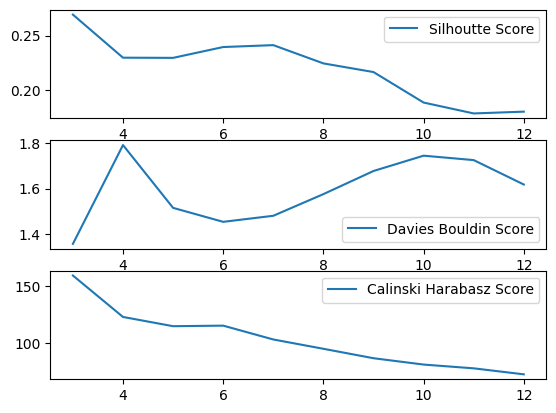

In [15]:
x = [3,4,5,6,7,8,9,10,11,12]
plt.subplot(3, 1, 1)
plt.plot(x, knn_silhoutte_score_list,label="Silhoutte Score")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(x, knn_db_score_list,label="Davies Bouldin Score")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(x, knn_ch_score_list,label="Calinski Harabasz Score")
plt.legend()
plt.show()
# cluster of 2 has max score

#### External Evaluation

In [16]:
n_clusters = 3
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto").fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

if clusters is not None:
  cluster_labels = clusters.labels_

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))


# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid



# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 129.7736142844584
Prediction accuracy MAPE: 8.49012375450369


cluster_id_weekdays_share [94, 8, 134]
cluster_id_weekend_share [26, 75, 0]
111


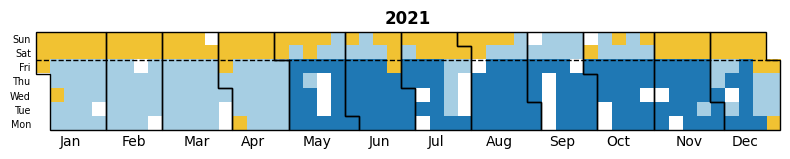

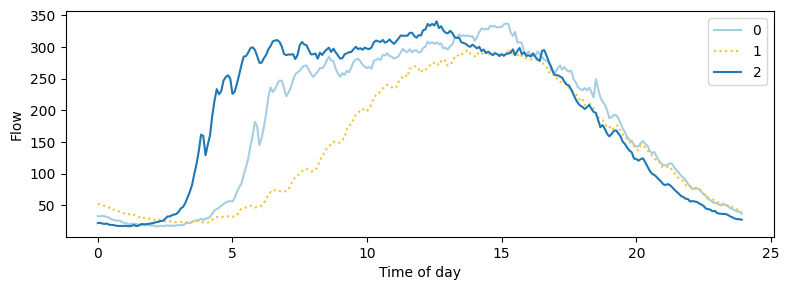

In [17]:
## Calendar Visualization

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)

## Day-time Profile of Centroids

# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

### Agglomerative Clustering

#### Internal Evaluation

In [18]:
ac_silhoutte_score_list = []
ac_db_score_list = []
ac_ch_score_list = []
# best_ac_para = []
for i in range (3,13):
    n_clusters = i
    clusters = None

    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]

    # BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
    clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

    if clusters is not None:
        cluster_labels = clusters.labels_

    
    ac_silhoutte_score_list.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    ac_db_score_list.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    ac_ch_score_list.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    
    # s = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    # d = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    # c = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    # best_ac_para.append("{:.8f}".format(float(s*math.exp(-d)*c)))
    

    # Print the computed cluster quality scores
    print('Agglomerative Clustering with', n_clusters, 'clusters')
    print('Silhouette Score:', ac_silhoutte_score_list[i-3])
    print('Davies-Bouldin Score:', ac_db_score_list[i-3])
    print('Calinski-Harabasz Score:', ac_ch_score_list[i-3],' \n')
    print(cluster_labels,'\n')
    # print("My evaluation scores for each cluster: ",best_ac_para, "\n")
    

    # cluster of 2

Agglomerative Clustering with 3 clusters
Silhouette Score: 0.26811197169820694
Davies-Bouldin Score: 1.3138114813630548
Calinski-Harabasz Score: 148.6076053377012  

[2 2 2 0 0 2 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2
 0 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0
 0 2 2 0 0 0 0 0 2 0 0 2 2 2 2 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 0 0
 0 0 0 2 0 1 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 2 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 2 0 1 1 1 1 0 0 1 1 1 1 1
 0 2 1 1 1 1 1 0 2 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1 1 1 2 2 1 1 1 0 2 2 2 0
 0 0 0 2] 

Agglomerative Clustering with 4 clusters
Silhouette Score: 0.2576366497624237
Davies-Bouldin Score: 1.460274078411172
Calinski-Harabasz Score: 127.

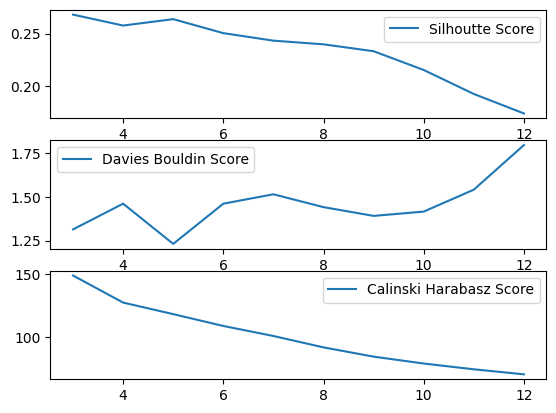

In [19]:
x = [3,4,5,6,7,8,9,10,11,12]
plt.subplot(3, 1, 1)
plt.plot(x, ac_silhoutte_score_list,label="Silhoutte Score")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(x, ac_db_score_list,label="Davies Bouldin Score")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(x, ac_ch_score_list,label="Calinski Harabasz Score")
plt.legend()
plt.show()

#### External Evaluation

In [20]:
n_clusters = 5
clusters = None
#print(np.where(nans_per_day > 0)[0])
vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]

clusters = AgglomerativeClustering(n_clusters=n_clusters,metric='euclidean', linkage='ward').fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

if clusters is not None:
  cluster_labels = clusters.labels_

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))


# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid



# Calculate centroids for each cluster
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 5

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 59.98865522321583
Prediction accuracy MAPE: 3.318357803607238


cluster_id_weekdays_share [128, 30, 6, 71, 1]
cluster_id_weekend_share [0, 53, 46, 0, 2]
111


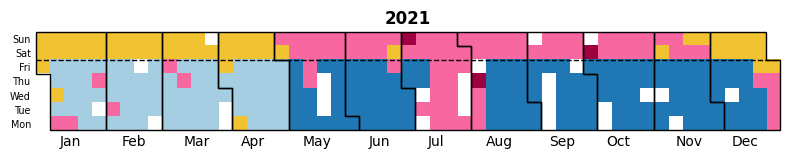

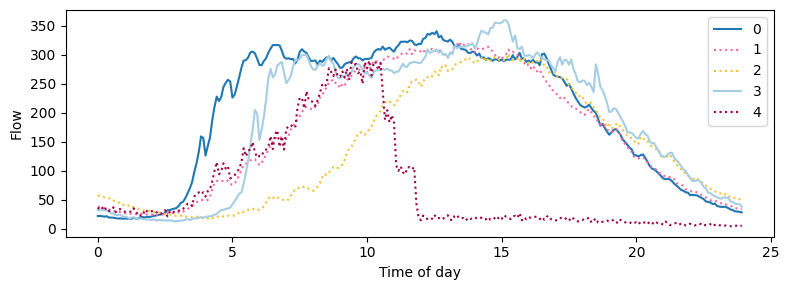

In [21]:

# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

### DBSCAN

#### Internal Evaluation

In [22]:
dbscan_silhoutte_score_list = []
dbscan_db_score_list = []
dbscan_ch_score_list = []
# epsilon = [700,800,900,1000,1200,1300,1500] #,1200,1300,1300,1400]
epsilon = [900,1000,1200,1300,1300]
# best_db_para = []

for i in range (3,8):
    
    
    clusters = None

    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]

    # BELOW lines enables you to comment in and out clustering method you want to use note that GMM have different ouput and thus labels are extracted differently
    clusters = DBSCAN(eps=epsilon[i-3], min_samples = 2).fit(vectorized_day_dataset_no_nans) 

    if clusters is not None:
        cluster_labels = clusters.labels_

        
    dbscan_silhoutte_score_list.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    dbscan_db_score_list.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    dbscan_ch_score_list.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))

    # s = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    # d = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    # c = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    # best_db_para.append("{:.8f}".format(float(s*math.exp(-d)*c)))    

    # Print the computed cluster quality scores
    print('DBSCAN with', 'epsilon ',epsilon[i-3], 'and ', i, ' clusters') 
    print('Silhouette Score:', dbscan_silhoutte_score_list[i-3])
    print('Davies-Bouldin Score:', dbscan_db_score_list[i-3])
    print('Calinski-Harabasz Score:', dbscan_ch_score_list[i-3],' \n')
    print(cluster_labels,'\n')

# print("My evaluation scores for each cluster: ",best_db_para, "\n")

# cluster of 5

DBSCAN with epsilon  900 and  3  clusters
Silhouette Score: 0.3215211842981234
Davies-Bouldin Score: 2.5024569667208594
Calinski-Harabasz Score: 11.678293919806908  

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0

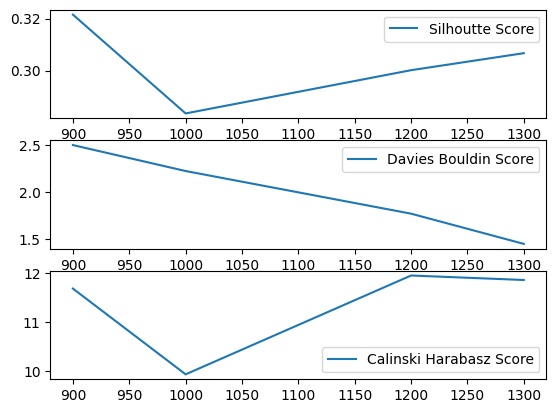

In [23]:
plt.subplot(3, 1, 1)
plt.plot(epsilon, dbscan_silhoutte_score_list,label="Silhoutte Score")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(epsilon, dbscan_db_score_list,label="Davies Bouldin Score")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(epsilon, dbscan_ch_score_list,label="Calinski Harabasz Score")
plt.legend()
plt.show()

#### External Evaluation

In [24]:
n_clusters = 4
clusters = None

vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]


clusters = DBSCAN(eps=1300, min_samples = 2).fit(vectorized_day_dataset_no_nans) # check the parameters at https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

if clusters is not None:
  cluster_labels = clusters.labels_

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid



# Calculate centroids for each cluster FOR DBSCAN THE STUPID CLUSTER NAMES ARE -1,0,1 THEREFORE THE I NEEDS -1
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i-1)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 9

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 60.67715427657878
Prediction accuracy MAPE: 3.357302511251115


cluster_id_weekdays_share [233, 1, 2]
cluster_id_weekend_share [99, 2, 0]
111


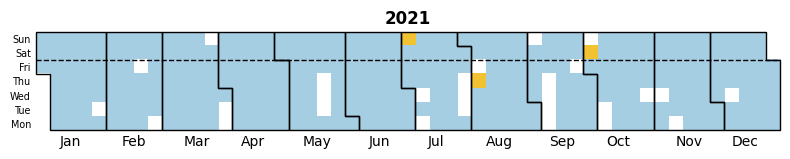

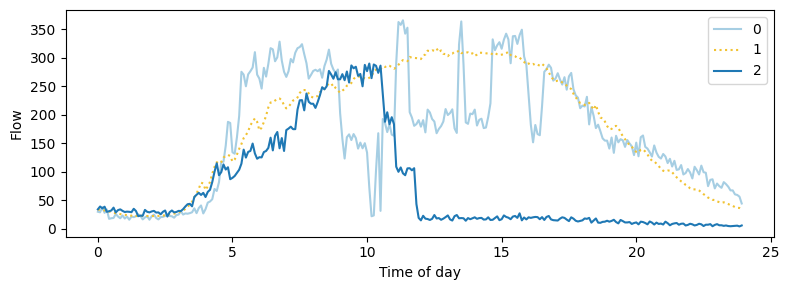

In [25]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i-1)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.

### GNN

#### Internal Evaluation

In [26]:
gnn_silhoutte_score_list = []
gnn_db_score_list = []
gnn_ch_score_list = []
# best_gnn_para = []
for i in range (2,13):
    n_clusters = i
    clusters = None

    vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
    days_not_nans = days[np.where(nans_per_day == 0)[0]]

    if clusters is not None:
        cluster_labels = clusters.labels_

    cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans) #check the parameters at  https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_init.html#sphx-glr-auto-examples-mixture-plot-gmm-init-py

    gnn_silhoutte_score_list.append(silhouette_score(vectorized_day_dataset_no_nans, cluster_labels))
    gnn_db_score_list.append(davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels))
    gnn_ch_score_list.append(calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels))
    
    # s = silhouette_score(vectorized_day_dataset_no_nans, cluster_labels)
    # d = davies_bouldin_score(vectorized_day_dataset_no_nans, cluster_labels)
    # c = calinski_harabasz_score(vectorized_day_dataset_no_nans, cluster_labels)
    # best_gnn_para.append("{:.8f}".format(float(s*math.exp(-d)*c)))

    # Print the computed cluster quality scores
    print('GNN with', n_clusters, 'clusters')
    print('Silhouette Score:', gnn_silhoutte_score_list[i-2])
    print('Davies-Bouldin Score:', gnn_db_score_list[i-2])
    print('Calinski-Harabasz Score:', gnn_ch_score_list[i-2],' \n')
    print(cluster_labels,'\n')
    
# print("My evaluation scores for each cluster: ",best_gnn_para, "\n")
    # cluster of 2

GNN with 2 clusters
Silhouette Score: 0.3031591919834656
Davies-Bouldin Score: 1.2838898479316692
Calinski-Harabasz Score: 169.67082782741105  

[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1
 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0
 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1
 1 1 1 1] 

GNN with 3 clusters
Silhouette Score: 0.3084810936365804
Davies-Bouldin Score: 0.9894411944760712
Calinski-Harabasz Score: 108.0268151063098  

[1 1 1 1 1 1 1 1 1 1 0 1

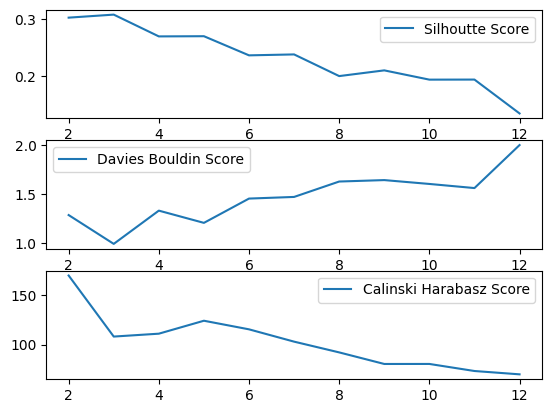

In [27]:
x = [2,3,4,5,6,7,8,9,10,11,12]
plt.subplot(3, 1, 1)
plt.plot(x, gnn_silhoutte_score_list,label="Silhoutte Score")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(x, gnn_db_score_list,label="Davies Bouldin Score")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(x, gnn_ch_score_list,label="Calinski Harabasz Score")
plt.legend()
plt.show()

#### External Evaluation

In [28]:
n_clusters = 3
clusters = None

vectorized_day_dataset_no_nans = vectorized_day_dataset[np.where(nans_per_day == 0)[0],:]
days_not_nans = days[np.where(nans_per_day == 0)[0]]


cluster_labels = GaussianMixture(n_components=n_clusters).fit(vectorized_day_dataset_no_nans).predict(vectorized_day_dataset_no_nans)

if clusters is not None:
  cluster_labels = clusters.labels_

# Initialize a list to store centroid data
centroids = []
n_clusters_t = len(np.unique(cluster_labels))

# Import the pairwise_distances function from scikit-learn's metrics library
import sklearn.metrics.pairwise as dis_lib

# Define a function to find the closest centroid to a new data point within a specified day-time interval range
def find_the_closest_centroid(centroids, new_day, from_interval: int, to_interval: int):
    closest_centroid = None
    closest_dist = None

    # Iterate through each centroid
    for i in range(0, len(centroids)):
        # Calculate the Euclidean distance between the centroid and the new data point
        ed_t = dis_lib.paired_distances(centroids[i], new_day, metric='euclidean')

        # Check if the current centroid is closer than the previously closest one
        if closest_centroid is None or closest_dist > ed_t:
            closest_centroid = i
            closest_dist = ed_t

    return closest_centroid



# Calculate centroids for each cluster FOR DBSCAN THE STUPID CLUSTER NAMES ARE -1,0,1 THEREFORE THE I NEEDS -1
for i in range(0, n_clusters_t):
    centroid = np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).reshape(1, nintvals)
    centroids.append(centroid)

# Define the number of past intervals to consider for classification
n_past_intervals_for_classification = 9

# Initialize variables to calculate accuracy metrics
total_mae = 0
total_mape = 0
prediction_counts = 0

# Loop through each day in the evaluation dataset with no missing values
for i in range(0, ndays_eval_not_nans):
    # Loop through intervals from n_past_intervals_for_classification to nintvals - 1
    for j in range(n_past_intervals_for_classification, nintvals - 1):
        # Find the closest centroid for the current data point
        centroid_index = find_the_closest_centroid(centroids, vectorized_day_dataset_no_nans_eval[i].reshape(1, nintvals), j - n_past_intervals_for_classification, j)

        # Predict the value for the next interval
        predicted_value = centroids[centroid_index][0, j + 1]

        # Calculate Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE)
        mae_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1])
        mape_t = abs(predicted_value - vectorized_day_dataset_no_nans_eval[i][j + 1]) / float(vectorized_day_dataset_no_nans_eval[i][j + 1])

        # Accumulate MAE, MAPE, and count of predictions
        total_mae += mae_t
        total_mape += mape_t
        prediction_counts += 1

# Calculate and print the prediction accuracy metrics
print('Prediction accuracy MAE:', total_mae / prediction_counts)
print('Prediction accuracy MAPE:', total_mape / prediction_counts)

Prediction accuracy MAE: 128.1694807027722
Prediction accuracy MAPE: 8.408447465010566


cluster_id_weekdays_share [8, 135, 93]
cluster_id_weekend_share [61, 0, 40]
111


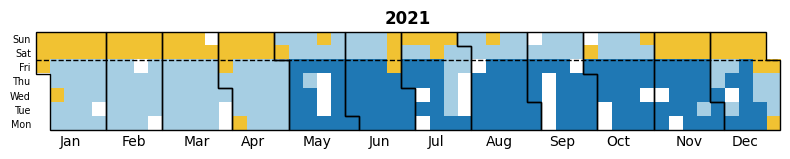

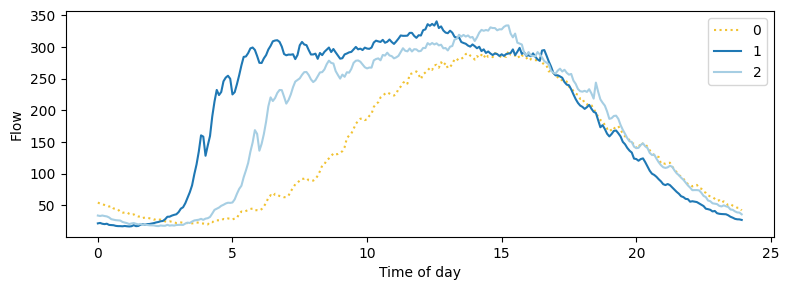

In [29]:
# Calculate the number of clusters by finding unique values in 'cluster_labels'
n_clusters_t = len(np.unique(cluster_labels))

# Assign colors to days based on clusters
days_colors, color_to_cluster, style_to_cluster = assign_colors(n_clusters_t, days_not_nans, cluster_labels)
# The function 'assign_colors' is used to determine colors and styles for visualization.

# Create a calendar visualization figure
make_calendar_visualization_figure(days_not_nans, cluster_labels, n_clusters_t, [2021], days_colors,
                                   color_to_cluster, save_figure=None)
# Initialize empty lists to store centroid data
centroids_xx = []  # x-axis values for centroids
centroids_yy_daytypes = []  # y-axis values for centroids, grouped by day types
cluster_ids = []  # Cluster IDs

# Iterate through each cluster
for i in range(0, n_clusters_t):
    # Store the x-axis values for centroids (hours of the day)
    centroids_xx.append(x_axis_hours)

    # Calculate the y-axis values for centroids (average flow for each 5-minute interval)
    centroid_yy = list(np.nanmean(vectorized_day_dataset_no_nans[np.where(cluster_labels == i)[0], :], 0).transpose())
    centroids_yy_daytypes.append(centroid_yy)

    # Store the cluster ID
    cluster_ids.append(i)

# Generate a figure displaying the centroids
make_figure_centroids(centroids_xx, centroids_yy_daytypes, color_to_cluster, style_to_cluster, cluster_ids)
# The function 'make_figure_centroids' is used to create a visualization of the centroids,
# with the provided data and parameters.